In [27]:
%matplotlib inline


训练一个分类器
=====================

关于数据
----------------

通常，当你处理图像，文本，音频和视频数据时，你可以使用标准的Python包来加载数据到一个numpy数组中。然后把这个数组转换成``torch.*Tensor``。

-  对于图像，有Pillow, OpenCV
-  对于音频,有scipy，librosa
-  对于文本，原始Python和Cython来加载，或者NLTK和SpaCy是有用的。

对于视觉,创建了一个``torchvision``，包含常见数据集的数据加载比如Imagenet，CIFAR10，MNIST等。另外还有图像的数据转换器``torchvision.datasets``和``torch.utils.data.DataLoader``.

对于本教程，我们将使用CIFAR10数据集。
类别有：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。CIFAR-10的图像为3x32x32。
<center><img src="img/cifar10.png" width="30%"/></center>


训练一个图像分类器
----------------------------

我们将一次按照下列顺序进行:

1. 使用torchvision加载和归一化CIFAR10训练集和测试集.
2. 定义一个卷积神经网络
3. 定义损失函数
4. 在训练集上训练网络
5. 在测试集上测试网络

## 1 加载和归一化CIFAR10


使用``torchvision``加载CIFAR10是非常容易的。

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision输出是[0,1]的PILImage图像,我们把它转换为归一化范围为[-1, 1]的tensor。


In [29]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


展示一些训练图像

 bird   dog  ship  deer


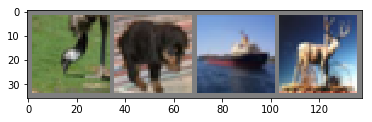

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2 定义一个卷积神经网络

从之前的神经网络一节复制神经网络代码,并修改为输入为3通道图像。


In [31]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3 定义损失函数和优化器

使用交叉熵作为损失函数,使用带momentum的随机梯度下降。



In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4 训练网络


只需在数据迭代器上循环,将数据输入给网络,并优化



In [38]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#net.to(device)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.151
[1,  4000] loss: 1.801
[1,  6000] loss: 1.625
[1,  8000] loss: 1.542
[1, 10000] loss: 1.485
[1, 12000] loss: 1.441
[2,  2000] loss: 1.392
[2,  4000] loss: 1.358
[2,  6000] loss: 1.318
[2,  8000] loss: 1.296
[2, 10000] loss: 1.302
[2, 12000] loss: 1.271
Finished Training


## 5 在测试集上测试网络

上面在训练集上训练了两次，即2个epoch。现在验证下网络是否学习到了东西。

In [42]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

现在看看神经网络认为这些图是什么：



In [41]:
outputs = net(images)

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'

输出的是10个类别的分数，一个类别的分数越大，神经网络认为他是这个类别的概率越大。分数最高的标签是：


In [23]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


结果看起来还不错，现在看下在整个数据集上的效果


In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


比随机猜测的结果略好。现在看看在什么类上预测较好，什么类上预测不好：


In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 74 %
Accuracy of  bird : 52 %
Accuracy of   cat : 34 %
Accuracy of  deer : 49 %
Accuracy of   dog : 39 %
Accuracy of  frog : 46 %
Accuracy of horse : 66 %
Accuracy of  ship : 64 %
Accuracy of truck : 67 %


在GPU上如何运行呢?

在GPU上训练
----------------
与把Tensor迁移到GPU上一样,神经网络迁移到GPU也是类似的。

如果CUDA可用的话，首先定义一个可见的CUDA设备 :

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


本节的其余部分假设设备是CUDA设备。

然后，这些方法将递归地遍历所有模块，并将它们的参数和缓冲区转换为CUDA的Tensor：

```python

    net.to(device)
```

记住你也得把每一步中的输入和目标值转换到GPU上：

```python

    inputs, labels = inputs.to(device), labels.to(device)
```
为什么没有看到GPU对速度提升很大呢？因为网络很小

**练习：** 尝试增加网络宽度 (第1个``nn.Conv2d``的第2个参数,第2个``nn.Conv2d``的第1个参数，这两个参数要相同),看一看速度的变化。

**实现的目标**:

- 理解PyTorch的Tensor库神经网络
- 训练小的神经网络分类图像

多GPU训练
-------------------------
使用所有的GPU可以看到速度大幅提升,请查看`data_parallel_tutorial`。

接下来做什么?
-------------------

-  [训练神经网络玩电子游戏](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
-  [在ImageNet上训练最好的ResNet](https://github.com/pytorch/examples/tree/master/imagenet)
-  [使用对抗生成网络（GAN）来训练一个人脸生成器](https://github.com/pytorch/examples/tree/master/dcgan)
-  [使用LSTM网络训练一个字符级的语言模型](https://github.com/pytorch/examples/tree/master/word_language_model)
-  [更多示例](https://github.com/pytorch/examples)
-  [更多教程](https://github.com/pytorch/tutorials)
-  [在论坛上讨论PyTorch](https://discuss.pytorch.org/)
-  [在Slack上与其他用户聊天](http://pytorch.slack.com/messages/beginner/)
